# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
<b>Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>

[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] </b>We could use the Score/Rating. A rating of 4 or 5 could be considered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral, so it is ignored. This is an approximate way of determining the polarity (positivity/negativity) of a review.




##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I have used the SQLITE dataset as it is easier to query the data and better visualisation of the data.
<br> 

Here, the purpose is only to get the global sentiment of the recommendations (positive or negative). So we can ignore all reviews with scores of 3. If the score is above 3, then the review will be marked as "positive", otherwise it will be marked as "negative".

In [323]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os



In [4]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 as negative and greater than 3 as positive
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our dataset", filtered_data.shape)
filtered_data.head()

Number of data points in our dataset (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
display = pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE UserId = "A395BORC6FGVXV"''',con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
1,136304,B002Y7526Y,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,544173,B000U9WZ54,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table above) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [19]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was found that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delete the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one review for each product and user.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.shape

(525814, 10)

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> 
1. After removing the duplicates, we are now left with 69% of the original data.
2. It was also seen that in two rows, the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
# Remove reviews with Helpfulness Numerator greater than Helpfulness Denominator 
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

<b>Observation:-</b> 
1. Data set is imbalanced dataset with 16% negative reviews and 84% positive reviews.

# [3].  Text Preprocessing.

Now that we have finished deduplication, our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the given order:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was found that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:00<00:00, 2014.64it/s]


In [31]:
len(final)

364171

In [26]:
final['processed_reviews'] = preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of the review

###  Visualizing Data

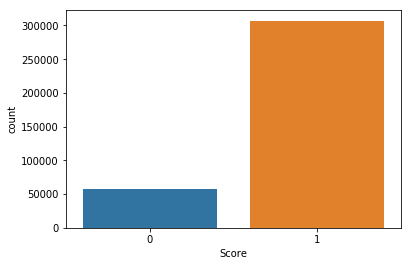

In [34]:
sns.countplot(data=final,x='Score')

In [75]:
#define style for seaborn
def set_style():
    plt.subplots(figsize=(15,6))
    sns.set_style("whitegrid")
    sns.despine()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.color_palette('dark')

Text(0.5, 1.0, 'PDF for review length')

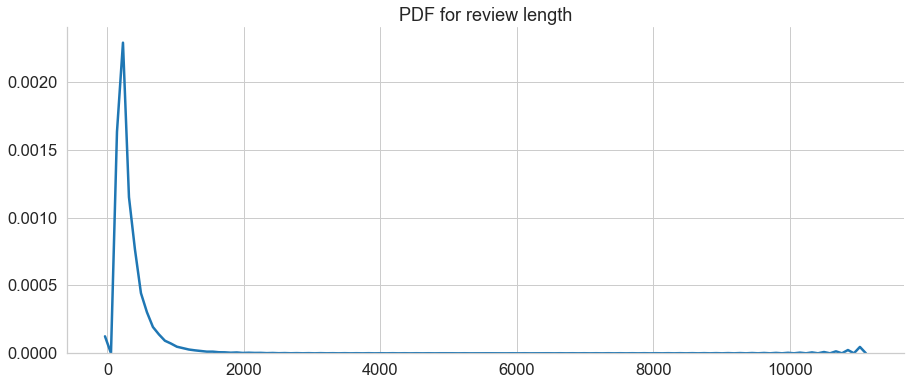

In [39]:
#length of text of each review
def length(x):
    return len(x)

rev_len=list(final['processed_reviews'].map(length))
#pdf of reviews
set_style()
sns.distplot(rev_len,hist=False).set_title('PDF for review length')

<b> Observations-:</b>
Review length follows power law distribution.

         count  year
364166  178145  2012
364167  173675  2012
364168  204727  2012
364169    5259  2012
364170  302474  2012


Text(0.5, 1.0, 'User reviews yearwise')

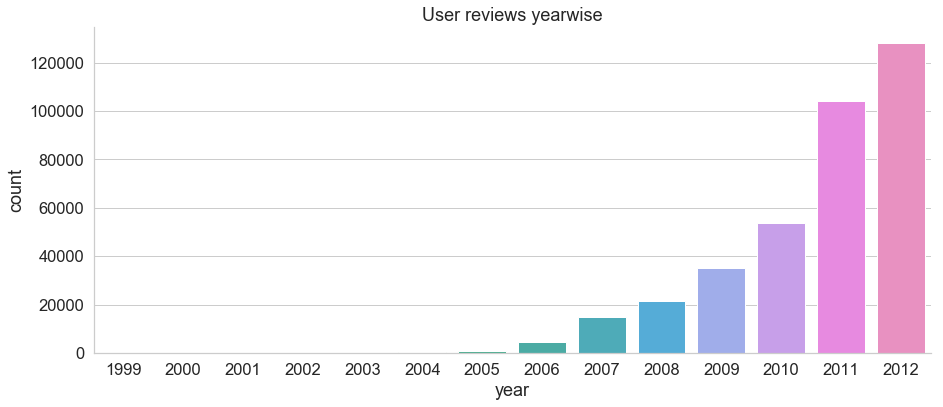

In [51]:
#convert time stamp to date and column as data

set_style()
a = pd.to_datetime(final['Time'], unit='s')
years=a.map(lambda x:x.year)
years=years.reset_index()
years.columns=['count','year']

sns.countplot(data=years,x='year').set_title('User reviews yearwise')

In [72]:
years[years['year']==2012].count()

count    128209
year     128209
dtype: int64

<b> Observations-:</b>
1. Maximum number of reviews were given in the year 2012.
2. Number of reviews given by users are increasing gradually every year.

Text(0.5, 1.0, 'Reviews given by users each month')

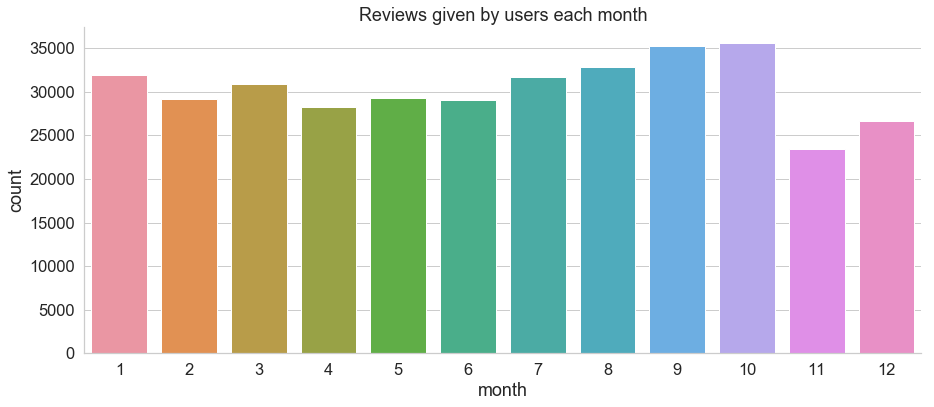

In [54]:
set_style()
a = pd.to_datetime(final['Time'], unit='s')
months=a.map(lambda x:x.month)
months=months.reset_index()
months.columns =['count','month']

sns.countplot(data=months,x='month').set_title('Reviews given by users each month')

In [ ]:
year[year[]]

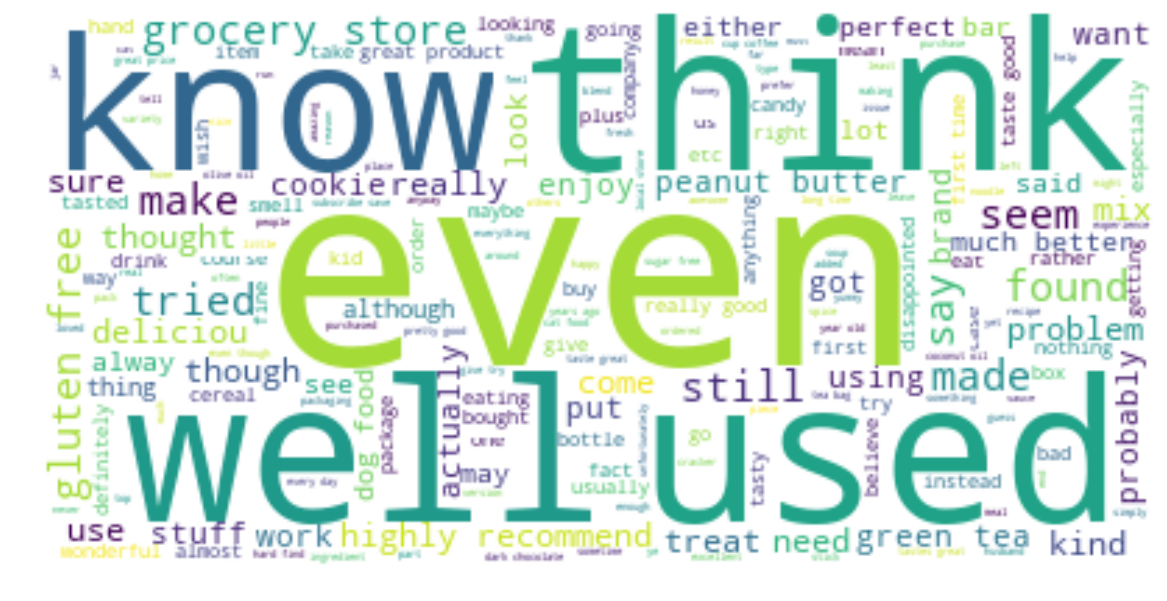

In [63]:
text_review = pd.Series(final.processed_reviews.values.flatten())
final_text_review = text_review.str.cat(sep=" ")
wordcloud_review = WordCloud(background_color="white").generate(final_text_review)
# Lines 2 - 5
plt.figure(figsize = (20,20))
plt.imshow(wordcloud_review, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Users given more reviews')

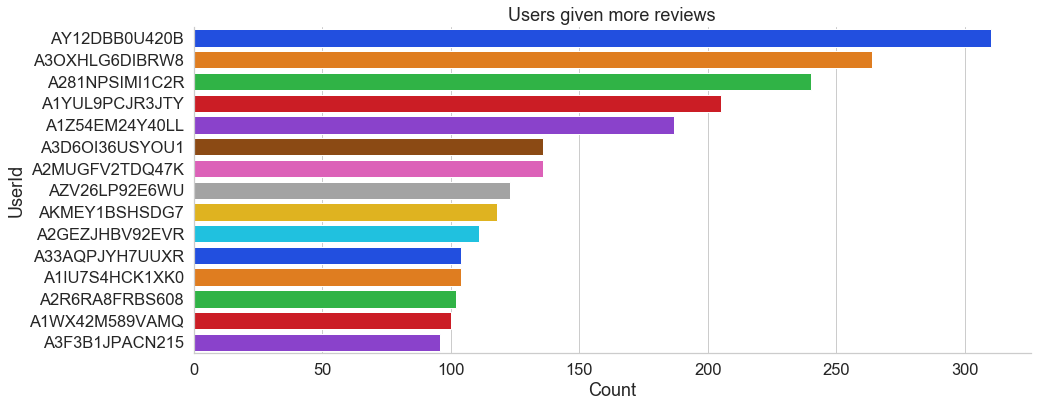

In [97]:
#top users
top = final.groupby(["UserId"])["UserId"].count().reset_index(name="Count")
top = top.sort_values('Count',ascending=False)[:15]
top.head(15)

set_style()
sns.barplot(data=top,x='Count',y='UserId',palette='bright').set_title('Users given more reviews')

In [104]:
#top positive rated product
positive = final[final['Score']==1]
top= positive.groupby('ProductId')['ProductId'].count().reset_index(name="Count")
top=top.sort_values('Count',ascending=False)[:10]
top

,ProductId,Count
58087,B007JFMH8M,840
38469,B003B3OOPA,585
31888,B0026RQTGE,571
24165,B001EO5Q64,538
14547,B000NMJWZO,527
17493,B000VK8AVK,457
16841,B000UBD88A,451
55493,B005ZBZLT4,417
15362,B000PDWBKO,405
54272,B005K4Q1YA,371


In [105]:
#top negative rated product
negative = final[final['Score']==0]
top= negative.groupby('ProductId')['ProductId'].count().reset_index(name="Count")
top=top.sort_values('Count',ascending=False)[:10]
top

,ProductId,Count
5305,B000KV61FC,167
18228,B0041NYV8E,146
7666,B000X1Q1G8,141
21892,B005K4Q1YA,141
2306,B000CNB4LE,129
20211,B004OAZ36I,122
22616,B006N3I69A,122
22608,B006MONQMC,106
20576,B004TJF3BE,106
22640,B006Q820X0,98


##  Machine Learning models

<b>Task</b>:<br> Build a Machine learning model such that given a new review our model should predict the polarity of the review without any information about product and user.

###  Sampling Data
Since we have a huge dataset, we just take a sample of data and build machine learning models.

In [293]:
#We take a sample of 300,000 data points
from sklearn.utils import resample
sample = resample(final,n_samples=300000)

In [294]:
sample.shape

(300000, 11)

###  Train, CV ,Test Split
<p3> Given data contains time split and also reviews might have an impact on the time of the review given. So we consider <b>time based splitting</b> for train, cv, test.
</p3>

We consider Train - 65% , CV - 15%, and test - 20% 

In [295]:
# sort our sampled data based on time in ascending order
sample = sample.sort_values(by='Time',kind='quicksort')

#splitting 65% as train 15% as cv and 20% as test data
a = int(sample.shape[0] * 0.80)
b = int(a * 0.8125)

X_train = sample.iloc[:b,:]
X_cv = sample.iloc[b:a]
X_test = sample.iloc[a:,:]

# print train,cv and test size
print('train size is:',X_train.shape)
print('cv size is:',X_cv.shape)
print('test size is:',X_test.shape)

train size is: (195000, 11)
cv size is: (45000, 11)
test size is: (60000, 11)


## Feature in to Vecor

Since the review data we have is text feature, we will use TFIDF and BOW vectorization

#### Separating the target variable i.e. score

In [296]:
y_train = X_train['Score']
y_cv = X_cv['Score']
y_test = X_test['Score']

### BOW

In [297]:
###  Covert text to vectors using BoW
bow = CountVectorizer()
X_train_bow_vect  = bow.fit_transform(X_train['processed_reviews'])


In [305]:
X_cv_bow_vect  = bow.transform(X_cv['processed_reviews'])
X_test_bow_vect  = bow.transform(X_test['processed_reviews'])

In [327]:
data = np.array(['This is a horrible product I have used so far',
                 'Very tasty chips ever',
                'This soap smells disgusting',
                'this bread smells bad but tastes good'])
s = pd.Series(data)
df_bow_vect  = bow.transform(s)

In [344]:
df_bow_vect.shape

(4, 69033)

In [345]:
y_df_predicted = model.predict(df_bow_vect)
y_df_predicted


ValueError: dimension mismatch

In [302]:
print(X_train_bow_vect.shape)
print(X_cv_bow_vect.shape)
print(X_test_bow_vect.shape)

(195000, 69033)
(45000, 69033)
(60000, 69033)


### TF-IDF

In [303]:
#We will consider uni-grams and bi-grams
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_tfidf_vect  = tfidf_vect.fit(X_train['processed_reviews'])


In [304]:
print("some sample features(unique words in the corpus)",X_tfidf_vect.get_feature_names()[-150:-50])
print('='*50)

some sample features(unique words in the corpus) ['yummy chewy', 'yummy chocolate', 'yummy chummies', 'yummy coffee', 'yummy cookies', 'yummy earth', 'yummy easy', 'yummy eat', 'yummy enough', 'yummy especially', 'yummy even', 'yummy filling', 'yummy flavor', 'yummy flavors', 'yummy get', 'yummy good', 'yummy goodness', 'yummy great', 'yummy healthy', 'yummy highly', 'yummy kids', 'yummy like', 'yummy little', 'yummy love', 'yummy made', 'yummy makes', 'yummy much', 'yummy must', 'yummy no', 'yummy not', 'yummy perfect', 'yummy product', 'yummy pumpkin', 'yummy put', 'yummy recommend', 'yummy sauce', 'yummy snack', 'yummy snacks', 'yummy stuff', 'yummy sure', 'yummy sweet', 'yummy taste', 'yummy tastes', 'yummy tasting', 'yummy think', 'yummy though', 'yummy treat', 'yummy treats', 'yummy way', 'yummy well', 'yummy wish', 'yummy would', 'yummy year', 'yummy yummy', 'yummyearth', 'yummyearth organic', 'yums', 'yunnan', 'yup', 'zantac', 'zap', 'zapped', 'zatarain', 'zatarains', 'zeal', '

In [308]:
features = X_tfidf_vect.get_feature_names()

In [309]:
X_train_tfidf_vect = X_tfidf_vect.transform(X_train['processed_reviews'])
X_cv_tfidf_vect = X_tfidf_vect.transform(X_cv['processed_reviews'])
X_test_tfidf_vect = X_tfidf_vect.transform(X_test['processed_reviews'])

In [310]:
print(X_train_tfidf_vect.shape)
print(X_cv_tfidf_vect.shape)
print(X_test_tfidf_vect.shape)

(195000, 115757)
(45000, 115757)
(60000, 115757)


In [311]:
#print top tfidf words.
#High tfidf value implies word is more important compared to less tfidf value word.


# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(X_train_tfidf_vect[1,:].toarray()[0],features,15)
top_tfidf

,feature,tfidf
0,not dull,0.261890
1,starring,0.261890
2,paced,0.252790
3,geena davis,0.234483
4,geena,0.234483
5,captured,0.230535
6,tim burton,0.230535
7,michael keaton,0.227675
8,burton,0.227675
9,masterpiece,0.224635


###  1. Naive Bayes with BOW

Naive Bayes model works well for text related problems. So lets try that first

In [312]:
#function to give various scores on test data for a given model.
def performance_metrics(y_predicted,y_actual):
    conf_mat = confusion_matrix(y_predicted,y_actual)
    TN, FN, FP, TP = conf_mat[0][0],conf_mat[0][1],conf_mat[1][0],conf_mat[1][1]
    P = TP+FN
    N = TN+FP
    TPR = TP/P
    FPR = FP/P
    FNR = FN/N
    TNR = TN/N
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score =  2 * (precision * recall) / (precision + recall)
    acc = accuracy_score(y_predicted, y_actual)
    print('Various metrics of model:')
    print('TPR is:',TPR)
    print('FPR is:',FPR)
    print('TNR is:',TNR)
    print('FPR is:',FPR)
    print('Precision is:',precision*100)
    print('Recall is:',recall*100)  
    print('F1 score is:',f1_score*100)
    print('Accuracy is:',acc*100,'\n')
    
    key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
    #fig, ax = plt.subplots(1,2, figsize=(12,5))
    labels = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten()
    , conf_mat.flatten())])).reshape(2,2)

    print('Confusion Matrix is:')
    #ax = sns.heatmap(confusion_matrix(y_predicted,y_actual),annot=True,fmt='g',cbar=None)
    sns.heatmap(conf_mat, linewidths=.5, xticklabels=['Predicted : 0', 'Predicted : 1'],
    yticklabels=['Actual : 0', 'Actual : 1'], annot = labels, fmt = '')

    plt.show()

In [313]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [314]:
#function to print top 10 positive and negative features
def imp_features(vectorizer, clf):
    feature_names = vectorizer.get_feature_names()
    n = clf.coef_[0].shape[0]
    coefs_with_features = sorted(zip(clf.coef_[0], feature_names))
    positive = coefs_with_features[:n-11:-1]
    negative = coefs_with_features[:10]
    positive = [i[1] for i in positive]
    negative = [i[1] for i in negative]

    top = {'positive':positive,'negative':negative}
    print('Top positive and negative features/words')
    top = pd.DataFrame(data=top)
    return top

Lets compare the cross validation scores and decide the best 
hyperparameter alpha

For alpha = 0.000001, cv score is : 0.856267
For alpha = 0.000010, cv score is : 0.858467
For alpha = 0.000100, cv score is : 0.860511
For alpha = 0.001000, cv score is : 0.864333
For alpha = 0.010000, cv score is : 0.867356
For alpha = 0.100000, cv score is : 0.869556
For alpha = 1.000000, cv score is : 0.881578
For alpha = 10.000000, cv score is : 0.867178
For alpha = 100.000000, cv score is : 0.821911
For alpha = 1000.000000, cv score is : 0.821911


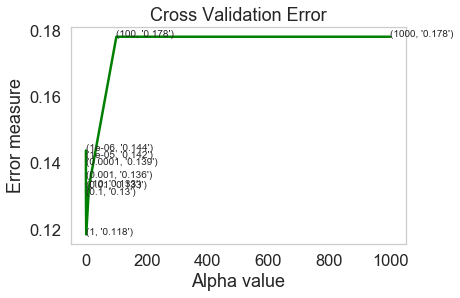


The optimal alpha is 1.000000.


In [342]:
cv_error = []
param_alpha = [10**x for x in range(-6,4)]

for i in param_alpha:
    clf = MultinomialNB(alpha=i,fit_prior=None)
    clf.fit(X_train_bow_vect, y_train)
    
    y_cv_predicted = clf.predict(X_cv_bow_vect)
    score = accuracy_score(y_cv, y_cv_predicted)   
    
    #score = clf.score(X_cv_bow_vect, y_cv)
    print('For alpha = %f, cv score is : %f' %(i,score))
    cv_error.append(1-score)

#plot errors and cv scores
fig, ax = plt.subplots()
ax.plot(param_alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((param_alpha[i],str(txt)), (param_alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error")
plt.xlabel("Alpha value")
plt.ylabel("Error measure")
plt.show()

# determining best alpha
optimal_alpha = param_alpha[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is %f.' % optimal_alpha)

Now let's train our model using the best alpha= 1.000

Various metrics of model:
TPR is: 0.8984491440080564
FPR is: 0.04004028197381672
TNR is: 0.8079227053140097
FPR is: 0.04004028197381672
Precision is: 95.73353935960168
Recall is: 89.84491440080564
F1 score is: 92.69580034494939
Accuracy is: 88.28333333333333 

Confusion Matrix is:


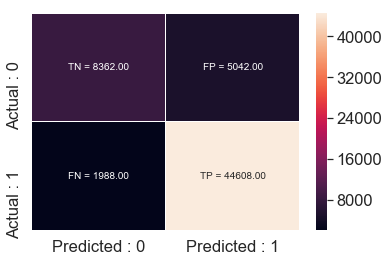

In [343]:
bow_model = MultinomialNB(alpha=optimal_alpha,fit_prior=None)
bow_model.fit(X_train_bow_vect, y_train)
y_test_predicted = bow_model.predict(X_test_bow_vect)
score = accuracy_score(y_test, y_test_predicted)

#Performance of the model on the test data
#print('Test score is : %f' %score)

performance_metrics(y_test_predicted, y_test)

#### Train the model with best alpha 

In [317]:
#Lets get some of the important features/words for both positive and negative classes
imp_features(bow, bow_model)

Top positive and negative features/words


,positive,negative
0,not,aaaaa
1,like,aaaaaahhhhhyaaaaaa
2,good,aachen
3,great,aachener
4,one,aarrgh
5,taste,abalone
6,tea,abated
7,flavor,abbazabba
8,product,abbreviated
9,love,abe


###  2. Naive Bayes with TF-IDF

For alpha = 0.000001, cv score is : 0.885711
For alpha = 0.000010, cv score is : 0.890222
For alpha = 0.000100, cv score is : 0.896667
For alpha = 0.001000, cv score is : 0.901600
For alpha = 0.010000, cv score is : 0.903844
For alpha = 0.100000, cv score is : 0.899511
For alpha = 1.000000, cv score is : 0.913133
For alpha = 10.000000, cv score is : 0.827156
For alpha = 100.000000, cv score is : 0.822044
For alpha = 1000.000000, cv score is : 0.822044


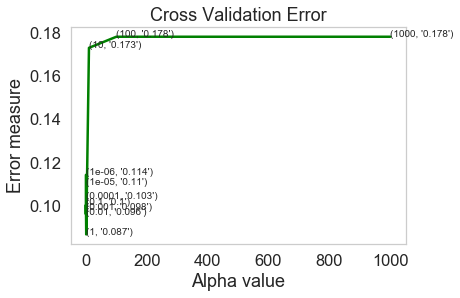


The optimal alpha is 1.000000.


In [318]:
cv_error = []
param_alpha = [10**x for x in range(-6,4)]

for i in param_alpha:
    clf = MultinomialNB(alpha=i,fit_prior=None)
    clf.fit(X_train_tfidf_vect, y_train)
    
    y_cv_predicted = clf.predict(X_cv_tfidf_vect)
    score = accuracy_score(y_cv, y_cv_predicted)   
    
    #score = clf.score(X_cv_bow_vect, y_cv)
    print('For alpha = %f, cv score is : %f' %(i,score))
    cv_error.append(1-score)

#plot errors and cv scores
fig, ax = plt.subplots()
ax.plot(param_alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((param_alpha[i],str(txt)), (param_alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error")
plt.xlabel("Alpha value")
plt.ylabel("Error measure")
plt.show()

# determining best alpha
optimal_alpha = param_alpha[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is %f.' % optimal_alpha)

Various metrics of model:
TPR is: 0.9427391742195368
FPR is: 0.045337361530715006
TNR is: 0.782512077294686
FPR is: 0.045337361530715006
Precision is: 95.41155367116474
Recall is: 94.27391742195368
F1 score is: 94.83932406694493
Accuracy is: 91.51 

Confusion Matrix is:


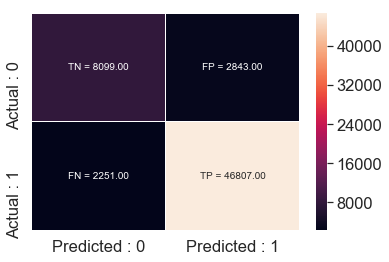

In [319]:
tfidf_model = MultinomialNB(alpha=optimal_alpha,fit_prior=None)
tfidf_model.fit(X_train_tfidf_vect, y_train)
y_test_predicted = tfidf_model.predict(X_test_tfidf_vect)
score = accuracy_score(y_test, y_test_predicted)

#Performance of the model on the test data
#print('Test score is : %f' %score)

performance_metrics(y_test_predicted, y_test)

In [320]:
#Lets get some of the important features/words for both positive and negative classes
imp_features(tfidf_vect, tfidf_model)

Top positive and negative features/words


,positive,negative
0,not,absolutely worst
1,great,advertising not
2,good,allow returns
3,like,almost gagged
4,tea,amazon ashamed
5,coffee,avoid cost
6,love,away remainder
7,product,awful coffee
8,taste,awful first
9,one,awful maybe


##  Logistic Regression

###  Logistic Regression with BOW

For C = 0.000010, cv score is : 0.692578
For C = 0.000100, cv score is : 0.804089
For C = 0.001000, cv score is : 0.852600
For C = 0.010000, cv score is : 0.880600
For C = 0.100000, cv score is : 0.893578
For C = 1.000000, cv score is : 0.896978
For C = 10.000000, cv score is : 0.892711
For C = 100.000000, cv score is : 0.892467


NameError: name 'my_c' is not defined

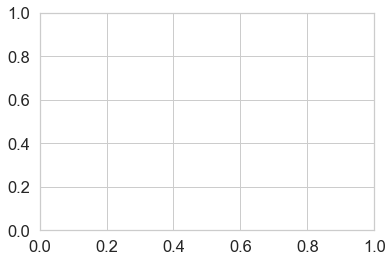

In [324]:
cv_error = []
param_c = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
for i in param_c:
    clf = LogisticRegression(C=i,class_weight='balanced')
    clf.fit(X_train_bow_vect, y_train)
    score = clf.score(X_cv_bow_vect,y_cv)
    print('For C = %f, cv score is : %f' %(i,score))
    cv_error.append(1-score)
    
#plot errors and cv scores
fig, ax = plt.subplots()
ax.plot(param_c, cv_error, c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((param_c[i],str(txt)), (param_c[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each C")
plt.xlabel("C 's")
plt.ylabel("Error measure")
plt.show()

# determining best C
optimal_c = param_c[cv_error.index(min(cv_error))]
print('\nThe optimal C is %f.' % optimal_c)
    

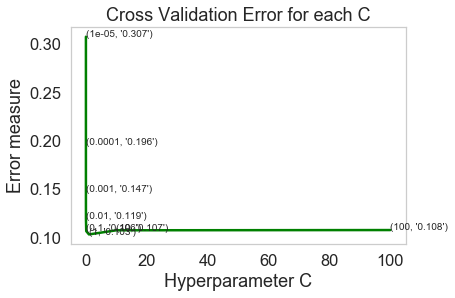


The optimal C is 1.000000.


In [326]:

#plot errors and cv scores
fig, ax = plt.subplots()
ax.plot(param_c, cv_error, c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((param_c[i],str(txt)), (param_c[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each C")
plt.xlabel("Hyperparameter C")
plt.ylabel("Error measure")
plt.show()

# determining best C
optimal_c = param_c[cv_error.index(min(cv_error))]
print('\nThe optimal C is %f.' % optimal_c)

Various metrics of model:
TPR is: 0.9139174219536758
FPR is: 0.03615307150050352
TNR is: 0.8265700483091788
FPR is: 0.03615307150050352
Precision is: 96.19469589366348
Recall is: 91.39174219536757
F1 score is: 93.73173175240909
Accuracy is: 89.885 

Confusion Matrix is:


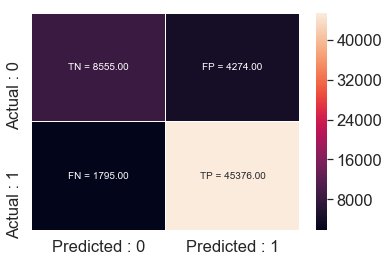

In [330]:
#train model with C.
clf = LogisticRegression(C=optimal_c,class_weight='balanced')
clf.fit(X_train_bow_vect, y_train)
#predict y labels with model on test data
predicted_y = clf.predict(X_test_bow_vect)
#Performance of the model on the test data
performance_metrics(predicted_y, y_test)


In [331]:
#Lets get some of the important features/words for both positive and negative classes
imp_features(bow, clf)

Top positive and negative features/words


,positive,negative
0,pleasantly,cocca
1,addicting,asnutty
2,satisfies,sleepless
3,hooked,hime
4,compromise,worst
5,delighted,disappointing
6,skeptical,sonewhere
7,happier,defeats
8,beat,disappointment
9,addicted,gauge


###  Logistic Regression with TFIDF

For C = 0.000010, cv score is : 0.709778
For C = 0.000100, cv score is : 0.796889
For C = 0.001000, cv score is : 0.822511
For C = 0.010000, cv score is : 0.847156
For C = 0.100000, cv score is : 0.886844
For C = 1.000000, cv score is : 0.917222
For C = 10.000000, cv score is : 0.928556
For C = 100.000000, cv score is : 0.927133


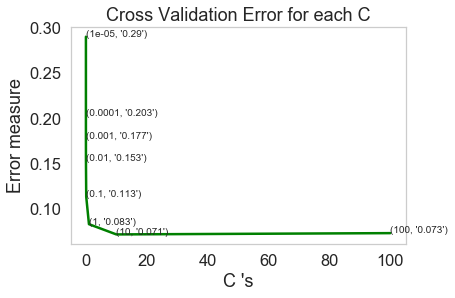


The optimal C is 10.000000.


In [332]:
cv_error = []
param_c = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
for i in param_c:
    clf = LogisticRegression(C=i,class_weight='balanced')
    clf.fit(X_train_tfidf_vect, y_train)
    score = clf.score(X_cv_tfidf_vect,y_cv)
    print('For C = %f, cv score is : %f' %(i,score))
    cv_error.append(1-score)
    
#plot errors and cv scores
fig, ax = plt.subplots()
ax.plot(param_c, cv_error, c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((param_c[i],str(txt)), (param_c[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each C")
plt.xlabel("C 's")
plt.ylabel("Error measure")
plt.show()

# determining best C
optimal_c = param_c[cv_error.index(min(cv_error))]
print('\nThe optimal C is %f.' % optimal_c)

Various metrics of model:
TPR is: 0.9487210473313192
FPR is: 0.03389728096676737
TNR is: 0.837391304347826
FPR is: 0.03389728096676737
Precision is: 96.55031053354377
Recall is: 94.87210473313192
F1 score is: 95.70385119416478
Accuracy is: 92.95166666666667 

Confusion Matrix is:


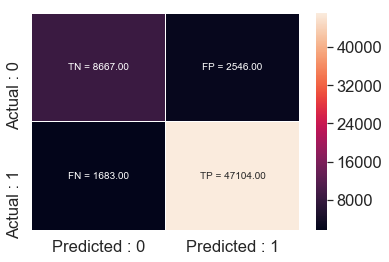

In [333]:
#train model with optimal C.
clf = LogisticRegression(C=optimal_c,class_weight='balanced')
clf.fit(X_train_tfidf_vect, y_train)
#predict y labels with model on test data
predicted_y = clf.predict(X_test_tfidf_vect)
#Performance of the model on the test data
performance_metrics(predicted_y, y_test)

In [334]:
#Lets get some of the important features/words for both positive and negative classes
imp_features(tfidf_vect,clf)

Top positive and negative features/words


,positive,negative
0,great,not worth
1,delicious,disappointed
2,not disappointed,worst
3,best,disappointing
4,good,not recommend
5,perfect,not good
6,loves,two stars
7,excellent,disappointment
8,wonderful,terrible
9,happy,candy delicious


### Models Summary

In [341]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Hyperparameter", "Accuracy", "F1-Score", "Precision", "Recall"]

x.add_row(["Naive Bayes-BOW", "Alpha=1.0", 88.28, 92.70, 95.73, 89.84 ])
x.add_row(["Naive Bayes-TFIDF", "Alpha=1.0", 91.51, 94.84, 95.41, 94.27])
x.add_row(["Logistic Regression-BOW", "C=1.0", 89.89, 93.73, 96.19, 91.39])
x.add_row(["Logistic Regression-TFIDF", "C=10.0", 92.95, 95.70, 96.55, 94.87])

print(x)

+---------------------------+----------------+----------+----------+-----------+--------+
|           Model           | Hyperparameter | Accuracy | F1-Score | Precision | Recall |
+---------------------------+----------------+----------+----------+-----------+--------+
|      Naive Bayes-BOW      |   Alpha=1.0    |  88.28   |   92.7   |   95.73   | 89.84  |
|     Naive Bayes-TFIDF     |   Alpha=1.0    |  91.51   |  94.84   |   95.41   | 94.27  |
|  Logistic Regression-BOW  |     C=1.0      |  89.89   |  93.73   |   96.19   | 91.39  |
| Logistic Regression-TFIDF |     C=10.0     |  92.95   |   95.7   |   96.55   | 94.87  |
+---------------------------+----------------+----------+----------+-----------+--------+


### Conclusion
<p>
Given data is highly imbalanced data with 84% positive and 16% negative score. Taking accuracy as a metric to measure perfomance of the model is a wrong idea because even a dumb model can have an accuracy of 84%. So we take F1 score, precision score and recall score in to consideration. Confusion matrices gives clear idea of FP and FN values and the performance of the models. 
<p>

1. From the above summary, we can clearly understand that Logistic Regression with TFIDF performs better with F1-score of 96%.    

2. If we observe the feature importance (positive and negative words) they are more reasonable and good.

3. From the confusion matrices we can conclude that more positive lables are mis-classified as negative, So False Positive value (FP) is high compared to False Negative (FN) values.